# Python Homework 2

**Release date:** Friday January 29<br>
**Due date:** Friday, __Frebruary 12 (!)__, at midnight via <font color="blue">Gradescope</font> 

**Instruction:** Please upload your jupyter notebook on <font color="blue">Gradescope</font> with filename __PythonHW2_YOURPERMNUMBER.ipynb__.


Load some packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats as st

## Problem 1 (10 Points)

Consider the continuous-time __Registration Line Markov Chain__ from Example 2.13 (Lecture 7).

1. Implement a simulation of this Markov chain on the time interval $[0,60]$. 

In [2]:
# define some help functions

def QtoPt(Q):
    """
    Compute the transition probability matrix Pt for embedded Markov chain
    from generator matrix Q
    
    Args:
        Q: generator matrix
    
    Ret:
        Pt: transition probability matrix for embedded Markov chain
    """
    # get the holding time parameter
    q = -np.copy(np.diag(Q))
    
    ds = q==0  # flags of dead states with zero holding time parameter
       
    # deal with the situation of the zero holding time
    q[ds] = 1
    
    # compute the embedded transition probability matrix
    Pt = Q/(q.reshape(-1,1))
    
    # process the values on the diagonal of the matrix
    Pt[np.diag_indices_from(Pt)] = 0
    Pt[ds, ds] = 1  # dead states
    
    return Pt

def sim_cmc_interval(Q, s0, interval):
    """
    Simulate continuous-time Markov chain on some interval
    
    Args:
        Q: generator matrix of the continuous-time Markov chain
        s0: initial state
        interval: (start, end)-tuple represents the time interval
    
    Ret:
        tlist: moments when the transition occurs
        slist: experienced states of the process
    """
    Pt = QtoPt(Q)  # transition probability for mbedded Markov chain
    
    # compute cumulative distribution for embedded Markov chain
    cPt = np.cumsum(Pt, axis=1)

    # initialize
    tstart, tend = interval
    t = tstart
    state = s0
    
    # store the initial values
    tlist = [t]
    slist = [state]
    
    while t < tend:
        # get holding time
        htime = st.expon.rvs(scale=-1/Q[state, state])
        
        # update t
        t += htime
        
        # tranlate the sate with some probability
        p = st.uniform.rvs()
        state = np.argwhere(p<cPt[state,:])[0][0]
    
        # store the result
        tlist.append(t)
        slist.append(state)

    tlist[-1] = tend
    
    return tlist, slist

In [3]:
# generator matrix Q from the transitition rate graph
Q = np.array([
    [-1/4,1/4,0,0,0],
    [1/5,-9/20,1/4,0,0],
    [0,1/5,-9/20,1/4,0],
    [0,0,1/5,-9/20,1/4],
    [0,0,0,1/5,-1/5]
])

# simulate the continuous-time Registration Line Markov Chain
tlist, slist = sim_cmc_interval(Q, 0, (0, 60))

2. Plot a trajectory of this Markov Chain on $[0,60]$ by using your code from 1.

<i>Hint:</i> You can use the <tt>plt.hlines()</tt> command to plot horizontal lines (check also the documentation online).

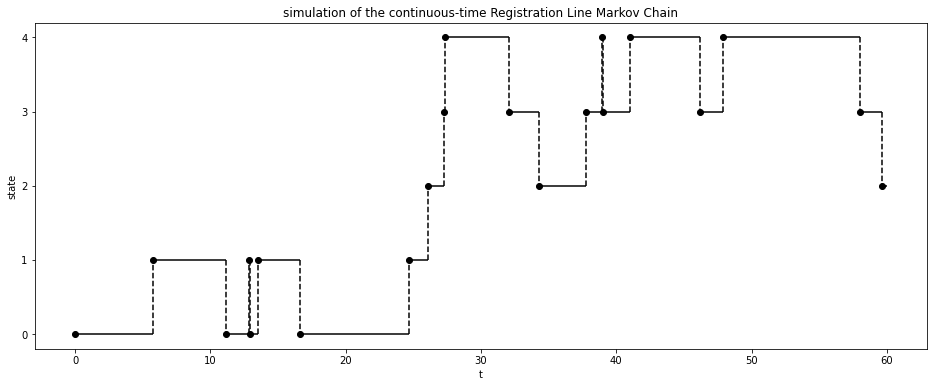

In [4]:
# create a figure and an axis
fig, ax = plt.subplots(1, 1, figsize=(16,6))

# plot the t - state graph
plt.hlines(slist[:-1], tlist[:-1], tlist[1:], colors='k', linestyles='-')
plt.vlines(tlist[1:-1], slist[:-2], slist[1:-1], colors='k', linestyles='--')
plt.plot(tlist[:-1], slist[:-1], 'ko')

# change the major locator of y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

# label and title
plt.xlabel('t')
plt.ylabel('state')
plt.title("simulation of the continuous-time Registration Line Markov Chain")

plt.show()

3. Compute the transition function $P(t)$ at $t = \pi$.

*Hint:* Use a suitable function from the <tt>scipy.linalg</tt> package (check also the documentation online).

In [5]:
# implement the transition function P(t)
P_f = lambda t: sp.linalg.expm(Q*t)

print('the transition probability P(pi) is')
print(P_f(np.pi))

the transition probability P(pi) is
[[0.55524989 0.308565   0.10512926 0.02554735 0.00550851]
 [0.246852   0.3925013  0.24489947 0.08909819 0.02664905]
 [0.06728272 0.19591958 0.37967644 0.24578083 0.11134043]
 [0.01308024 0.05702284 0.19662467 0.39747023 0.33580202]
 [0.00225628 0.01364431 0.07125787 0.26864162 0.64419991]]


4. Compute the stationary distribution of this continuous-time Markov chain.

*Hint:* Use suitable functions from the <tt>numpy.linalg package</tt> (check also the documentation online).

In [6]:
# the stationary distribution of this process is simply given by
# pQ = 0 where Q is the generator matrix

# compute the stationary distribution
s_dist = (sp.linalg.null_space(Q.T)).reshape(-1)
s_dist = s_dist/sum(s_dist)

print('the stationary distribution of this continuous-time Markov chain is')
print(s_dist)

the stationary distribution of this continuous-time Markov chain is
[0.12184674 0.15230842 0.19038553 0.23798191 0.29747739]


## Problem 2 (10 Points)

Multistate Markov models are used in medicine to model the course of diseases. A patient may advance into, or recover from, successively more severe stages of a disease until some terminal state. Each stage represents a state of an absorbing continuous-time Markov chain. 

Bartolomeo et al. (2011) develop such a model to study the progression of liver disease among patients diagnosed with cirrhosis of the liver. The general form of the infinitesimal generator matrix $Q$ for their three-parameter model is

$$ Q = \begin{pmatrix} -(q_{12} + q_{13}) & q_{12} & q_{13} \\ 0 & -q_{23} & q_{23} \\ 0 & 0 & 0 \end{pmatrix}  $$

where state 1 represents cirrhosis, state 2 denotes liver cancer, and state 3 is death.

1. Starting from the first stage ("cirrhosis"), estimate the mean time to death (i.e. ending up in stage 3) by running 100,000 simulations. Use the transition rates

$$ q_{12} = 0.0151, \quad q_{13} = 0.0071, \quad q_{23} = 0.0284.$$

In [7]:
# define some help functions

def sim_cmc_halt(Q, s0, halt):
    """
    Simulate continuous-time Markov chain until reaching the halt state
    
    Args:
        Q: generator matrix of the continuous-time Markov chain
        s0: initial state
        halt: halt state
    
    Ret:
        tlist: moments when the transition occurs
        slist: experienced states of the process
    """
    Pt = QtoPt(Q)  # transition probability for mbedded Markov chain
    
    # compute cumulative distribution for embedded Markov chain
    cPt = np.cumsum(Pt, axis=1)

    # initialize
    t = 0  # default start time
    state = s0
    
    # store the initial values
    tlist = [t]
    slist = [state]
    
    while state != halt:
        # get holding time
        htime = st.expon.rvs(scale=-1/Q[state, state])
        
        # update t
        t += htime
        
        # tranlate the sate with some probability
        p = st.uniform.rvs()
        state = np.argwhere(p<cPt[state,:])[0][0]
    
        # store the result
        tlist.append(t)
        slist.append(state)
    
    return tlist, slist

In [8]:
# transition rate
q12, q13, q23 = 0.0151, 0.0071, 0.0284

# generator matrix
Q = np.array([[-(q12+q13), q12, q13],
             [0,-q23,q23],
             [0,0,0]])

N = 100000  # simulation times

# store the results in an array
tdeaths = np.empty(N, 'double')

# simulate N times
for i in range(N):
    # get simulation results
    tlist, slist = sim_cmc_halt(Q, 0, 2)  # 0 for cirrhosis, 2 for death
    
    # get the time to death
    tdeaths[i] = tlist[-1]
    
# estimate the mean time to death
tdeath_sim = np.mean(tdeaths)

print('the simulated mean time to death is', tdeath_sim)

the simulated mean time to death is 69.28652401608558


2. Compare your approximation from 1. with the exact theoretical mean time to death (implement a suitable formula from class).  

In [9]:
# compute the theoretical mean time to death
tdeath_theo = 1/(q12+q13)+q12/(q23*(q12+q13))

print('the theoretical mean time to death is', tdeath_theo, '\n')

# compare both results
print('the simulated mean time to death minus the exact theoretical mean time to death is', tdeath_sim - tdeath_theo)

the theoretical mean time to death is 68.99505138941758 

the simulated mean time to death minus the exact theoretical mean time to death is 0.29147262666799634
